In [1]:
from helpers import *
import numpy as np
import pandas as pd
from implementations import *

import matplotlib.pyplot as plt


In [3]:
data_path = '../data/dataset_to_release'
x_train_preclean, x_test_preclean, y_train, train_ids, test_ids = load_csv_data(data_path)

# Getting an idea of the data

In [4]:
print("X train", x_train_preclean.shape)
print("X test", x_test_preclean.shape)

X train (328135, 321)
X test (109379, 321)


Text(0, 0.5, '# of columns')

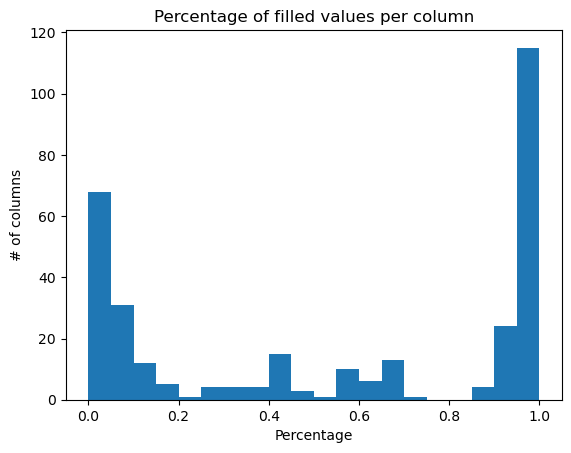

In [5]:
## Find how many values are completely empty in column
def percentageFilled(data):
    return 1 - np.isnan(data).sum() / len(data)

percentage_filled = np.apply_along_axis(percentageFilled, 0, x_train_preclean)

plt.hist(percentage_filled, bins=20)
plt.title("Percentage of filled values per column")
plt.xlabel("Percentage")
plt.ylabel("# of columns")

# Data Cleaning

In [5]:
## Process data 
## 1. drop the columns with more than 80% missing values
def threshold_col_filter(data, threshold):
    """ 
    filter out data where the column has less than threshold percentage of data
    returns: 
        indicies of columns to keep
    """
    percentage_filled = np.apply_along_axis(percentageFilled, 0, data)
    # keep_indicies = np.argwhere(percentage_filled > threshold).flatten()
    return percentage_filled > threshold


def non_constant_filter(data):
    """
    filter out where the values in the column are all the same
    """
    return np.logical_not(np.logical_or(np.isnan(np.nanstd(data, 0)), np.nanstd(data, 0) == 0))

# TODO uncorrelation?
    

# TODO correlation w
## SEE LATER, done at a later stage, after these two steps  


keep_indicies = np.argwhere(np.logical_and(
    threshold_col_filter(x_train_preclean, 0.2), 
    non_constant_filter(x_train_preclean))
).flatten()


In [6]:
def filter_columns_by_indicies(data, keep_indicies):
    """
    used to process test data 
    only keep the columns that are in the indicies 
    """
    return data[:, keep_indicies]


x_train = filter_columns_by_indicies(x_train_preclean, keep_indicies)
print("X train", x_train.shape)

x_test = filter_columns_by_indicies(x_test_preclean, keep_indicies)
print("X test", x_test.shape)

X train (328135, 201)
X test (109379, 201)


In [7]:
## now let's do the one hot encoding
def process_categorical(one_col):
    """ 
    why do I need this: some categorical data has this format (1, 2, 7, 9), but encoding needs it to be (0, 1, 2, 3) continuous discrete numbers 
    """
    unique_values = np.sort(np.unique(one_col))
    return_col = -1 * np.ones(one_col.shape)
    for i in range(len(unique_values)):
        return_col[one_col == unique_values[i]] = i 
    return return_col.astype(int)


def one_hot_encoding(one_col):
    b = np.zeros((one_col.size, len(np.unique(one_col))))
    b[np.arange(one_col.size), one_col] = 1
    
    return b

In [8]:
def is_categorical_feature(xn, threshold=10):
    return len(set(xn)) < threshold

# TODO: return two lists, indices of numerical and categorical features
def split_num_cat(data):
    is_cat_filter = np.apply_along_axis(is_categorical_feature, 0, data)
    cat_idx = np.argwhere(is_cat_filter == True).flatten()
    num_idx = np.argwhere(is_cat_filter == False).flatten()
    cat = data[:, is_cat_filter]
    num = data[:, np.logical_not(is_cat_filter)]
    return cat, num

# TODO: returns the exploded data, and the unique values for each categorical feature
def one_hot_encode(data): ## for training data exclusively 
    enum_x_train = np.apply_along_axis(process_categorical, 0, data)
    encoded_x_train = np.empty((len(enum_x_train), 0))
    for i in range(enum_x_train.shape[1]):
        encoded_x_train = np.append(encoded_x_train, one_hot_encoding(enum_x_train[:,i]), axis=1)
    return encoded_x_train

# TODO: explode based on the unique values of the training data
def one_hot_encode_test(data, unique_values):
    

In [42]:
# filter out the outliers
def remove_outliers(x_num, threshold = 3):
    x = x_num.copy()
    removed_count = 0
    for col in range(x.shape[1]):
        std = np.std(x[:, col])
        range_ = [-threshold*std, threshold*std]
        # Count outliers for this column
        removed_count_col = np.sum((x[:, col] < range_[0]) | (x[:, col] > range_[1]))
        removed_count += removed_count_col
        
        # Keep only values within the range
        x[np.logical_or(x[:, col] < range_[0], x[:, col] > range_[1])] = 0
        
    return x, removed_count

In [ ]:
## 2. Replace the missing values with the mean of the column, add columns 
def standardize(x):
    """Standardize the original data set."""
    return np.nan_to_num((x - np.nanmean(x, axis=0)) / np.nanstd(x, axis=0))


def process_data(data):
    # col_means = np.nanmean(x, axis=0)
    # inds = np.where(np.isnan(x))
    # x[inds] = np.take(col_means, inds[1])  # replace columns with values NaN with the mean of that column
    # x = (x - np.mean(x)) / np.std(x)  # standarize the data 
    ## ?? I feel like standardizing by column shouldn't be done like above 

    x_num, x_cat = split_num_cat(data)
    x_num = standardize(x_num)
    x_num, removed_cnt = remove_outliers(x_num)
    x_num = np.c_[np.ones(len(x_num)), x_num]  # add the column of ones
    x_cat = one_hot_encode(x_cat)
    return np.hstack((x_num, x_cat))


x_train_std = process_data(x_train)
x_test_std = process_data(x_test)
# print("x_train_std shape", x_train_std.shape)

# x_train_2 = process_data(x_train)
# x_test_2 = process_data(x_test_2)

In [23]:
x_num = standardize(x_num)

In [26]:
mx = np.apply_along_axis(max, 0, x_num)
mn = np.apply_along_axis(min, 0, x_num)

In [43]:
b, rcnt = remove_outliers(x_num)

In [46]:
b.shape

(109379, 130)

In [45]:
x_num.shape

(109379, 130)

In [18]:
remove_outliers(a)

(array([], shape=(0, 2), dtype=float64), 10)

In [ ]:
print(f"# num features: {x_train_std[0].shape}")

In [ ]:
## now let's do the one hot encoding
def process_categorical(one_col):
    """ 
    why do I need this: some categorical data has this format (1, 2, 7, 9), but encoding needs it to be (0, 1, 2, 3) continuous discrete numbers 
    """
    unique_values = np.sort(np.unique(one_col))
    return_col = -1 * np.ones(one_col.shape)
    for i in range(len(unique_values)):
        return_col[one_col == unique_values[i]] = i 
    return return_col.astype(int)


def one_hot_encoding(one_col):
    b = np.zeros((one_col.size, len(np.unique(one_col))))
    b[np.arange(one_col.size), one_col] = 1
    
    return b

In [ ]:
xn, xc = x_train_std
print(f"num shape: {xn.shape}, cat shape: {xc.shape}")

In [ ]:
len(np.where(abs(xn) > 3)[1])

### correlation 

In [ ]:
# Yiyuan's test code -- not sure how is this correlation numpy function working
# temp = np.array([[1, 2, 7], [19, 58, 37], [-2, 6, 14]])
# tempy = np.transpose(np.array([0, 3, -10]))
# print(temp)
# print("y", tempy)

# print("correlation is \n", np.corrcoef(temp, tempy, rowvar=False))

In [ ]:
def feature_correlation(x_train, y_train):
    return np.abs(np.corrcoef(x_train, y_train, rowvar=False))

cr  =  feature_correlation(x_train_std, y_train)[-1, :-1]
plt.hist(cr, bins=20)

In [ ]:
## Screen out features based on correlation
good_corre_indicies = np.argwhere(cr > 0.05).flatten()
print("good_corre_indicies", good_corre_indicies)
x_train_corre = x_train_std[:, good_corre_indicies]

# Logistic regression *without* regularization

In [ ]:
initial_w = np.zeros(x_train_corre.shape[1], dtype=np.float128)
max_iters = 100
gamma = 0.5

In [ ]:
## Here the logistic regression is from implementations.py
## 
w, loss = logistic_regression(y_train, x_train_corre, initial_w, max_iters, gamma)
print("loss is ", loss)


### Trying to predict x_test

In [ ]:
def prediction_labels(weights, data):  ## isn't this for linear regression only ? Don't we need the sigmoid?
    """Generates class predictions given weights, and a test data matrix."""
    y_pred = sigmoid(np.dot(data, weights))
    y_pred[np.where(y_pred >= 0.5)] = 1
    y_pred[np.where(y_pred < 0.5)] = 0
    return y_pred

y_pred = prediction_labels(w, x_train_corre)
temp = y_pred[y_pred != 0]


In [ ]:
def accuracy(y_pred, y_train):
    return (y_pred == y_train).sum() / len(y_train)
def precision(y_pred, y_train):
    TP = np.sum((y_train==1) & (y_pred==1))
    FP = np.sum((y_train==0) & (y_pred==1))
    return TP/(TP+FP)
def recall(y_pred, y_train):
    recall = np.sum((y_train==1) & (y_pred==1)) / np.sum(y_train==1)
    return recall
def f_score (y_pred, y_train):
    return 2*precision(y_pred, y_train)*recall(y_pred, y_train) / (precision(y_pred, y_train) + recall(y_pred, y_train))

print("accuracy", accuracy(y_pred, y_train))
print("precision", precision(y_pred, y_train))
print("recall", recall(y_pred, y_train))
print("f_score", f_score(y_pred, y_train))

## Generate trained data 

In [ ]:
##
y_pred = prediction_labels(w, x_test_std[:, good_corre_indicies])
y_pred[y_pred == 0] = -1

In [ ]:
create_csv_submission(test_ids, y_pred, 'submission.csv')

### Logistic regression with regularization